In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
polyA = 0b111001
polyB = 0b011011

def maxstar(a, b):
    result = np.empty_like(a)
    ainf = a == -np.inf
    binf = b == -np.inf
    result[ainf] = b[ainf]
    result[binf] = a[binf]
    noninf = (a != -np.inf) & (b != -np.inf)
    an = a[noninf]
    bn = b[noninf]
    result[noninf] = np.maximum(an, bn) + np.log1p(np.exp(-np.abs(an-bn)))
    return result

def process(simulated=False, skip_bit=False, dsn_convention=True, symbol_invert=False):
    mu = 1.0
    sigma = 0.25
    if simulated:
        # Simulated data
        message = np.random.randint(2, size=50000)
        state = np.random.randint(2**6)
        C1s = np.zeros(message.size)
        C2s = np.zeros(message.size)
        for j in range(message.size):
            C1s[j] = (len([a for a in bin(state & polyA)[2:] if a == '1']) + message[j]) % 2
            C2s[j] = (len([a for a in bin(state & polyB)[2:] if a == '1']) + message[j] + 1) % 2
            state = (state >> 1) | (message[j] << 5)
        C1s_clean = 2*C1s-1
        C2s_clean = 2*C2s-1
        C1s = mu*(2*C1s-1) + sigma * np.random.randn(C1s.size)
        C2s = mu*(2*C2s-1) + sigma * np.random.randn(C2s.size)
        symbols = np.zeros(2*C1s.size)
        # NASA/DSN convention for symbol ordering
        symbols[1::2] = C1s
        symbols[::2] = C2s
    else:
        # Recorded symbols
        symbols = np.fromfile(f'lev1_symbols.f32', dtype='float32')
        symbols = symbols[1:] if skip_bit else symbols[:]
        symbols = symbols[:symbols.size//2*2]
        if symbol_invert:
            symbols[1::2] *= -1
        # NASA/DSN convention for symbol ordering
        if dsn_convention:
            C1s = symbols[1::2]
            C2s = symbols[::2]
        else:
            C1s = symbols[::2]
            C2s = symbols[1::2]
        print('Crude estimate for noise standard deviation:')
        print('np.std(np.abs(symbols)) =', np.std(np.abs(symbols)))

    T = C1s.size # time steps
    nu = 6 # number of states = 2^nu
    Gamma = np.empty((T, 2**nu, 2**nu))
    Gamma[...] = -np.inf
    A = np.empty((T, 2**nu))
    A[...] = -np.inf
    A[0, :] = np.log(1/2**nu)
    B = np.empty((T, 2**nu))
    B[...] = -np.inf
    B[-1, :] = np.log(1/2**nu)
    Ap = np.zeros(T) # a priori information bit LLRs
    R1 = np.zeros(T) # LLRs for symbols on first branch
    R2 = np.zeros(T) # LLRs for symbols on second branch
    M = np.empty_like(Gamma)
    L = np.empty(T)

    R1[:] = -2*mu/sigma**2*C1s
    R2[:] = -2*mu/sigma**2*C2s

    # States are encoded as the concatenation of the
    # bits in the shift register, with the oldest bit
    # in the LSB, so that the shift register is shifted
    # left in each epoch.
    for r in range(2**nu):
        for s in range(2**nu):
            if r >> 1 == s & (2**(nu-1)-1):
                # S_r to S_s is a Trellis edge
                Gamma[:, r, s] = 0
                # The information bit corresponding to the
                # transition from S_r to S_s
                newbit = s >> (nu - 1)
                if newbit == 0:
                    Gamma[:, r, s] += np.log(np.exp(Ap)/np.exp(1 + np.exp(Ap)))
                else:
                    Gamma[:, r, s] += np.log(np.exp(-Ap)/np.exp(1 + np.exp(-Ap)))
                C1 = (len([a for a in bin(r & polyA)[2:] if a == '1']) + newbit) % 2
                C2 = (len([a for a in bin(r & polyB)[2:] if a == '1']) + newbit + 1) % 2
                if C1 == 0:
                    Gamma[:, r, s] += R1 - np.log1p(np.exp(R1))
                else:
                    Gamma[:, r, s] += -R1 - np.log1p(np.exp(-R1))
                if C2 == 0:
                    Gamma[:, r, s] += R2 - np.log1p(np.exp(R2))
                else:
                    Gamma[:, r, s] += -R2 - np.log1p(np.exp(-R2))

    # Note: For A, t is numbered from 0 to T-1,
    # while for Gamma and B, it is numbered from 1 to T
    for t in range(1, T):
        for r in range(2**nu):
            A[t, :] = maxstar(A[t, :], A[t-1, r] + Gamma[t-1, r, :])

    for t in range(T-2, -1, -1):
        for s in range(2**nu):
            B[t, :] = maxstar(B[t, :], B[t+1, s] + Gamma[t+1, :, s])
    
    M = A[:, :, np.newaxis] + Gamma + B[:, np.newaxis, :]

    Lp = np.empty_like(L)
    Lm = np.empty_like(L)
    Lp[:] = -np.inf
    Lm[:] = -np.inf
    for r in range(2**nu):
        for s in range(2**nu):
            if r >> 1 == s & (2**(nu-1)-1):
                newbit = s >> (nu - 1)
                if newbit == 1:
                    Lp = maxstar(Lp, M[:, r, s])
                else:
                    Lm = maxstar(Lm, M[:, r, s])
    L = Lp - Lm
    plt.figure()
    plt.plot(L, '.')
    plt.title('L')
    plt.ylabel('Log-likelyhood ratio')
    plt.xlabel('Bit number')
    
    if not simulated:
        # re-encode
        message = (L >= 0).astype('int')
        state = np.random.randint(2**6)
        C1s_clean = np.zeros(message.size)
        C2s_clean = np.zeros(message.size)
        for j in range(message.size):
            C1s_clean[j] = (len([a for a in bin(state & polyA)[2:] if a == '1']) + message[j]) % 2
            C2s_clean[j] = (len([a for a in bin(state & polyB)[2:] if a == '1']) + message[j] + 1) % 2
            state = (state >> 1) | (message[j] << 5)
        C1s_clean = 2*C1s_clean - 1
        C2s_clean = 2*C2s_clean - 1
    symbols_clean = np.zeros(symbols.size)
    # NASA/DSN convention for symbol ordering
    if dsn_convention:
        symbols_clean[1::2] = C1s_clean
        symbols_clean[::2] = C2s_clean
    else:
        symbols_clean[::2] = C1s_clean
        symbols_clean[1::2] = C2s_clean

    if simulated:
        skip = 0
    else:
        skip = 0
    symbols_wipe = (symbols_clean * symbols)[skip:]
    plt.figure()
    plt.plot(symbols_wipe, '.', alpha=0.01)
    plt.title('Wiped-off symbols')
    plt.xlabel('Symbol number')
    plt.ylabel('Amplitude')
    print('Wiped-off symbols average:', np.average(symbols_wipe), 'std:', np.std(symbols_wipe))

    print('SNR estimate on wiped-off symbols:')
    snr = np.average(symbols_wipe)**2/(2*np.std(symbols_wipe)**2)
    ebn0 = 2*snr
    print(f'SNR {10*np.log10(snr):.2f} dB')
    print(f'EbN0 {10*np.log10(ebn0):.2f} dB')
    
    print('Another SNR estimate:')
    snr = 0.5*np.average(symbols_wipe)**2/((np.sum(symbols_wipe**2)-np.sum(symbols_wipe)**2/symbols_wipe.size)/(symbols_wipe.size-3))
    ebn0 = 2*snr
    print(f'SNR {10*np.log10(snr):.2f} dB')
    print(f'EbN0 {10*np.log10(ebn0):.2f} dB')
    
    if not simulated:
        L.astype('float32').tofile('LLRs.f32')

Crude estimate for noise standard deviation:
np.std(np.abs(symbols)) = 0.26180893
Wiped-off symbols average: 0.8858375501339786 std: 0.2836299613508585
SNR estimate on wiped-off symbols:
SNR 6.88 dB
EbN0 9.89 dB
Another SNR estimate:
SNR 6.88 dB
EbN0 9.89 dB


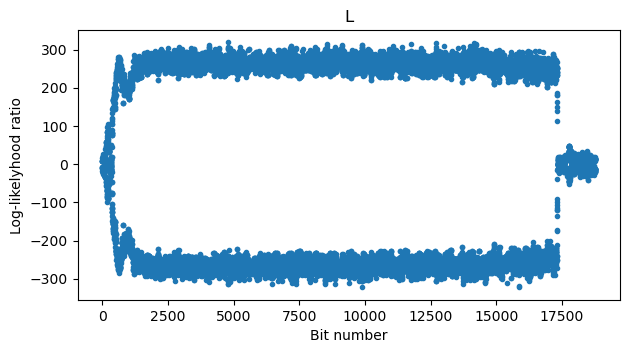

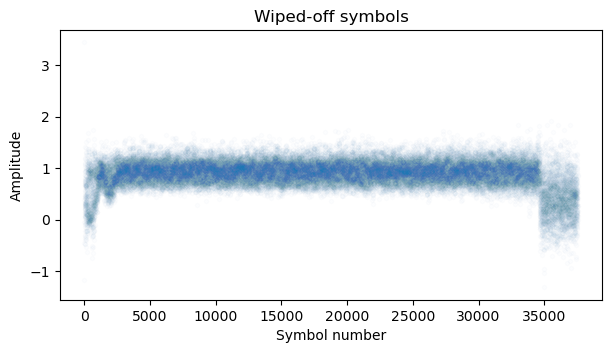

In [3]:
process(skip_bit=True, dsn_convention=False, symbol_invert=False)